# PDEFIND Feature Overview

This notebook provides a simple overview of the PDE functionality of PySINDy.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v0.13.0?filepath=example%2Ffeature_overview.ipynb)

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.linear_model import Lasso
from scipy.io import loadmat
import pysindy as ps

# Test PDE functionality on the 1D kdV equation
The kdV equation is
$u_t = -6uu_x - u_{xxx}$,
and the data we will be investigating is a two-soliton solution.

(512, 201) (201,) (512,)


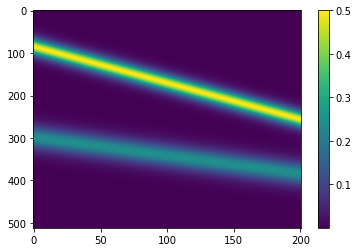

In [30]:
kdV = loadmat('data/kdv.mat')
t = np.ravel(kdV['t'])
x = np.ravel(kdV['x'])
u = np.abs(kdV['usol'])   #+ np.random.randn(len(x), len(t)) / 20
print(np.shape(u), np.shape(t), np.shape(x))
plt.imshow(u, aspect='auto')
plt.colorbar()

ut = np.zeros((len(x), len(t), 1))
for i in range(len(x)):
    u_temp = np.reshape(u[i, :], (len(u[i, :]), 1))
    ut[i, :] = ps.FiniteDifference()._differentiate(u_temp, t)

In [43]:
u_flattened = np.reshape(u, (len(x) * len(t), 1))
ut_flattened = np.reshape(ut, (len(x) * len(t), 1))
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(library_functions=library_functions, function_names=library_function_names, derivative_order=3, spatial_grid=x)
stlsq_optimizer = ps.STLSQ(threshold=0.2, alpha=0)
#stlsq_optimizer = ps.SR3(threshold=0.01, max_iter=10000, thresholder='l1')
#stlsq_optimizer = ps.SR3(threshold=0.01, max_iter=10000, thresholder='l1')


model = ps.SINDy(feature_library=pde_lib, optimizer=stlsq_optimizer)
model.fit(u_flattened)  #, x_dot=ut_flattened)
print(pde_lib.get_feature_names())
print(pde_lib.function_names)
model.print()
print(stlsq_optimizer.coef_)

['x0', 'x0x0', 'x0_z', 'x0_zz', 'x0_zzz', 'x0x0_z', 'x0x0x0_z', 'x0x0_zz', 'x0x0x0_zz', 'x0x0_zzz', 'x0x0x0_zzz']
[<function <lambda> at 0x7f22b982e9e0>
 <function <lambda> at 0x7f22b982eb00>
 <function PDELibrary.fit.<locals>.<lambda>.<locals>.<lambda> at 0x7f22be6b14d0>
 <function PDELibrary.fit.<locals>.<lambda>.<locals>.<lambda> at 0x7f22bc989f80>
 <function PDELibrary.fit.<locals>.<lambda>.<locals>.<lambda> at 0x7f22b9815440>]
x0' = -0.609 x0_zzz + -3.476 x0x0x0_z + -4.368 x0x0_zzz + -1.501 x0x0x0_zzz
[[ 0.          0.          0.          0.         -0.60885426  0.
  -3.47644501  0.          0.         -4.36787083 -1.50064938]]


(102912, 1)


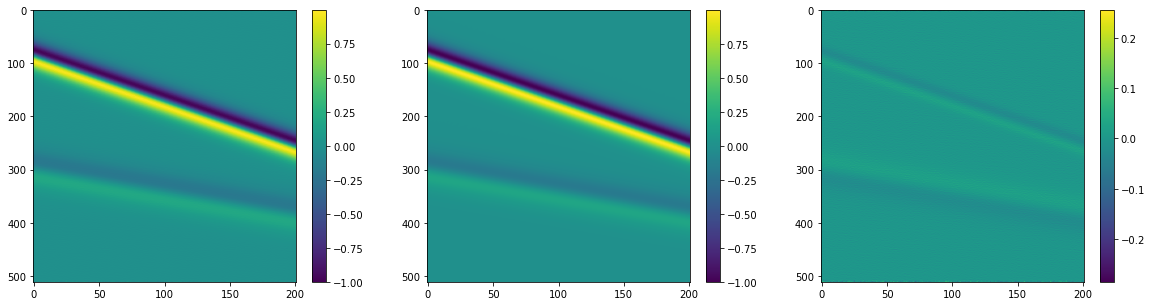

In [36]:
# Predict derivatives using the learned model
print(np.shape(u_flattened))
x_dot_test_predicted = model.predict(u_flattened)  
x_dot_test_predicted = np.reshape(x_dot_test_predicted, (len(x), len(t), 1))
# Compute derivatives with a finite difference method, for comparison

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.imshow(x_dot_test_predicted / np.max(np.abs(x_dot_test_predicted)), aspect='auto')
plt.colorbar()
plt.subplot(1, 3, 2)
plt.imshow(ut / np.max(np.abs(ut)), aspect='auto')
plt.colorbar()
plt.subplot(1, 3, 3)
plt.imshow(ut / np.max(np.abs(ut))-x_dot_test_predicted / np.max(np.abs(x_dot_test_predicted)), aspect='auto')
plt.colorbar()

In [37]:
print( np.max(np.abs(ut)) / np.max(np.abs(x_dot_test_predicted)))
print(np.max(np.abs(ut)) / np.max(np.abs(x_dot_test_predicted)) * stlsq_optimizer.coef_)

9.810757045547108
[[ 0.          0.         -0.14780299  0.         -6.85798758 -5.05171056
   0.          0.          0.          0.          0.        ]]
